## アウトライヤーエンジニアリング


外れ値とは、残りのデータとは大きく異なるデータポイントのことである。"外れ値とは、他の観測結果から大きく逸脱し、別のメカニズムで生成されたのではないかという疑念を抱かせるような観測結果のことである。" [D. Hawkins. Identification of Outliers, Chapman and Hall , 1980]とあります。

平均値や分散値などの統計は、外れ値の影響を非常に受けやすい。また、**機械学習のモデルの中には、外れ値に敏感なものがあり**、性能が低下することがあります。そのため、学習したいアルゴリズムに応じて、変数から外れ値を取り除くことがよくあります。

本コースのセクション3では、外れ値を特定する方法を説明しました。このセクションでは、機械学習モデルを学習するために、外れ値をどのように処理するかを説明します。


## どのようにして外れ値を前処理するのか？

- トリミング：データセットから外れ値を取り除く
- 外れ値を欠落データとして扱い、欠落データの入力技術を進める。
- Discrestisation: 外れ値を分布の高い値や低い値と一緒にボーダービンに入れる。
- 打ち切り：変数の分布の最大値または最小値に上限を設定する。

**打ち切り**は次のようにも呼ばれます。

- トップ＆ボトムコーディング
- winsorization
- キャッピング


## Censoring or Capping.

**打ち切り**、または**キャッピング**とは、分布の最大値、最小値を任意の値に制限することです。言い換えれば，任意に決められた値よりも大きな値や小さな値が**打ち切られる**ということです。

キャッピングは，変数とユーザに応じて，両方の尾部で行うことも，片方の尾部だけで行うこともできます。

金融会社でのキャッピングの例は、[pydata](https://www.youtube.com/watch?v=KHGGlozsRtA)の私の講演をご覧ください。

分布をキャップする数を決めることができます。

- 任意に
- 量的範囲間の近接ルールを用いて
- ガウス近似を用いる
- クオンタイルを使う


### 次のような利点があります。

- データを削除しない

### 制限事項

- 変数の分布が歪む
- 変数間の関係が歪む


## このデモでは

Boston House データセットを使用して、分位値間範囲近接ルールによるキャッピングを行う方法を説明します。

## 重要

キャッピングを行う際には、トレーニングセットとテストセットの両方で値をキャッピングする傾向があります。キャッピングの値は必ず訓練セットから得なければならないことを覚えておくことが重要です。そして、その同じ値をテストセットの変数のキャップに使用します。

今回のデモではそのようなことはしませんが、パイプラインをセットアップする際にはその点に注意してください。


In [ ]:

!pip install feature_engine

     |████████████████████████████████| 205 kB 6.6 MB/s 
     |████████████████████████████████| 9.8 MB 27.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Q-Qプロット用
import scipy.stats as stats

# デモ用ボストンハウスデータセット
from sklearn.datasets import load_boston

from feature_engine.outliers import Winsorizer

In [ ]:
# ボストンの住宅価格のデータを読み込む

# sklearnからボストンのデータセットを読み込む
boston_dataset = load_boston()


# 独立変数でデータフレームを作成する
# このデモでは、全変数のうち3つだけを使用します
boston = pd.DataFrame(boston_dataset.data,
                      columns=boston_dataset.feature_names)[[
                          'RM', 'LSTAT', 'CRIM'
                      ]]

#ターゲットの追加
boston['MEDV'] = boston_dataset.target

boston.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

,RM,LSTAT,CRIM,MEDV
0,6.575,4.98,0.00632,24.0
1,6.421,9.14,0.02731,21.6
2,7.185,4.03,0.02729,34.7
3,6.998,2.94,0.03237,33.4
4,7.147,5.33,0.06905,36.2


In [ ]:

# ヒストグラム、Q-Qプロット、ボックスプロットを作成する関数です。
# 箱ひげ図を作成する関数です。コースのセクション3で学びました


def diagnostic_plots(df, variable):
    # この関数は、データフレーム(df)と対象となる変数を引数として # 受け取ります。
    # 対象となる変数を引数として受け取ります。

    # 図形サイズの定義
    plt.figure(figsize=(16, 4))

    # ヒストグラム
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Qプロット
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # 箱ひげ図
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()


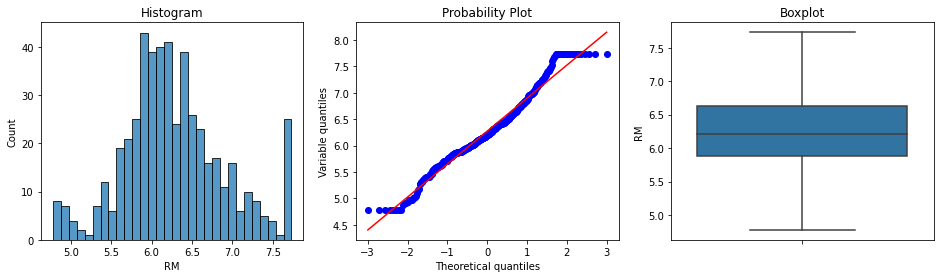

In [ ]:
# RMの外れ値を見つけよう

diagnostic_plots(boston, 'RM')

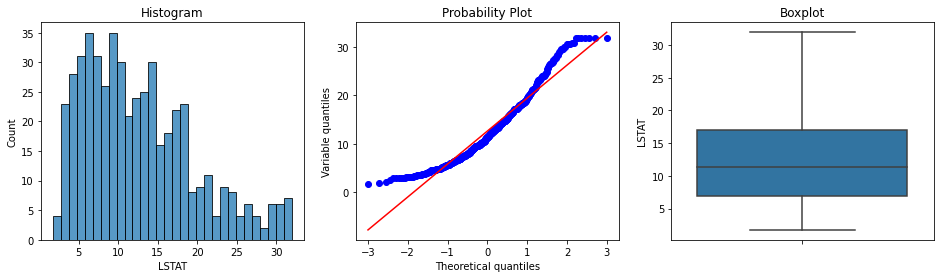

In [ ]:
# LSTATで外れ値を可視化する

diagnostic_plots(boston, 'LSTAT')

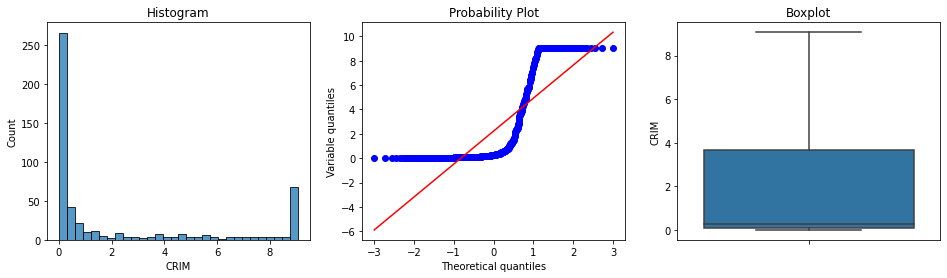

In [ ]:
# CRIMにおける外れ値

diagnostic_plots(boston, 'CRIM')

上記のすべての変数に外れ値があります。RMは両テールに外れ値を示していますが、LSTATとCRIMは右テールにのみ示しています。

はずれ値を見つけるために、第3節で学んだ関数を再度利用してみましょう。


In [ ]:
def find_skewed_boundaries(df, variable, distance):

    # 外れ値が存在する境界を計算しよう
    # 歪んだ分布の場合

    # 距離を引数として渡すと, 次のようなオプションがある.
    # IQRの1.5倍または3倍に見積もることができます。
    # 境界を計算します。


    IQR = df[Variable].quantile(0.75) - df[Variable].quantile(0.25)

    lower_boundary = df[Variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[Variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

In [ ]:
# RMの限界値を求める

RM_upper_limit, RM_lower_limit = find_skewed_boundaries(boston, 'RM', 1.5)
RM_upper_limit, RM_lower_limit

(7.730499999999999, 4.778500000000001)

In [ ]:
# LSTATの限界値

LSTAT_upper_limit, LSTAT_lower_limit = find_skewed_boundaries(boston, 'LSTAT', 1.5)
LSTAT_upper_limit, LSTAT_lower_limit

(31.962500000000006, -8.057500000000005)

In [ ]:
# CRIMの限界

CRIM_upper_limit, CRIM_lower_limit = find_skewed_boundaries(boston, 'CRIM', 1.5)
CRIM_upper_limit, CRIM_lower_limit

(9.06963875, -5.31051125)

In [ ]:
# では、外れ値を最大値と最小値に置き換えてみましょう

boston['RM']= np.where(boston['RM'] > RM_upper_limit, RM_upper_limit,
                       np.where(boston['RM'] < RM_lower_limit, RM_lower_limit, boston['RM']))

In [ ]:
# では、外れ値を最大値と最小値に置き換えてみましょう。

boston['LSTAT']= np.where(boston['LSTAT'] > LSTAT_upper_limit, LSTAT_upper_limit,
                       np.where(boston['LSTAT'] < LSTAT_lower_limit, LSTAT_lower_limit, boston['LSTAT']))

In [ ]:
# では、外れ値を最大値と最小値に置き換えてみましょう。

boston['CRIM']= np.where(boston['CRIM'] > CRIM_upper_limit, CRIM_upper_limit,
                       np.where(boston['CRIM'] < CRIM_lower_limit, CRIM_lower_limit, boston['CRIM']))

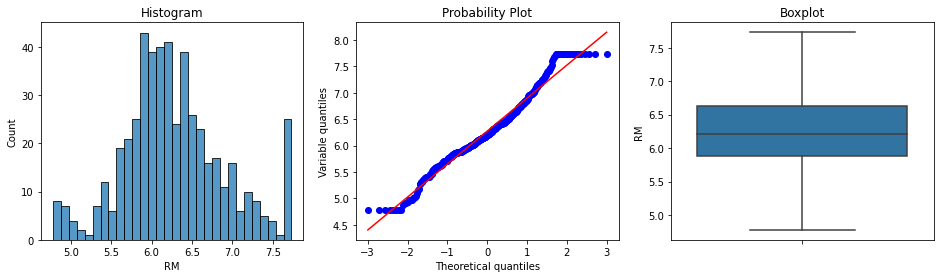

In [ ]:
# では、外れ値を最大値と最小値に置き換えてみましょう。
# RMの場合、元のデータセットに比べて外れ値が非常に少ないことがわかる

diagnostic_plots(boston, 'RM')

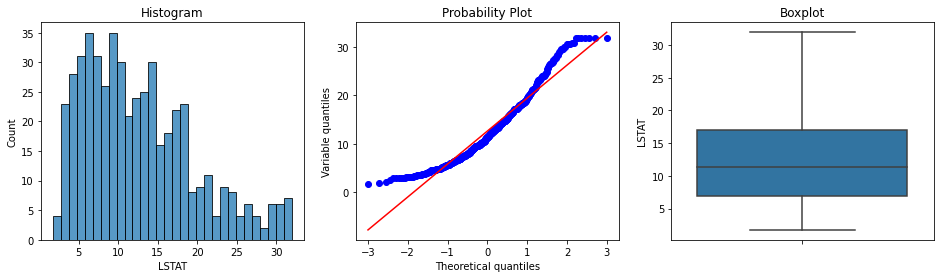

In [ ]:
diagnostic_plots(boston, 'LSTAT')

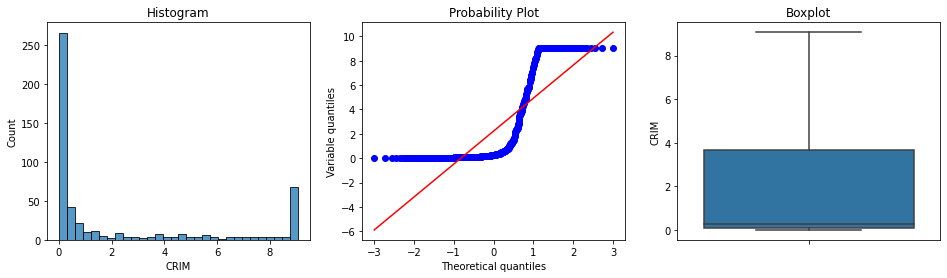

In [ ]:
diagnostic_plots(boston, 'CRIM')

外れ値はなくなったものの、変数の分布がかなり歪んでいることがわかります。

## Feature-engineによる打ち切り

In [ ]:

# load the Boston House price data

# sklearnからボストンのデータセットを読み込む
boston_dataset = load_boston()

# 独立変数でデータフレームを作成する
# このデモでは、全変数のうち3つだけを使用します

boston = pd.DataFrame(boston_dataset.data,
                      columns=boston_dataset.feature_names)[[
                          'RM', 'LSTAT', 'CRIM'
                      ]]

#ターゲットの追加
boston['MEDV'] = boston_dataset.target

boston.head()


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

,RM,LSTAT,CRIM,MEDV
0,6.575,4.98,0.00632,24.0
1,6.421,9.14,0.02731,21.6
2,7.185,4.03,0.02729,34.7
3,6.998,2.94,0.03237,33.4
4,7.147,5.33,0.06905,36.2


In [ ]:
# キャッパーの作成
windsoriser = Winsorizer(capping_method='iqr', # IQRルールの境界にはiqrを、平均値と標準値にはgaussianを選択する
                          tail='both', # 左尾、右尾、または両尾のキャップ 
                          fold=1.5,
                          variables=['RM', 'LSTAT', 'CRIM'])

windsoriser.fit(boston)


Winsorizer(capping_method='iqr', fold=1.5, tail='both',
           variables=['RM', 'LSTAT', 'CRIM'])

In [ ]:
boston_t = windsoriser.transform(boston)

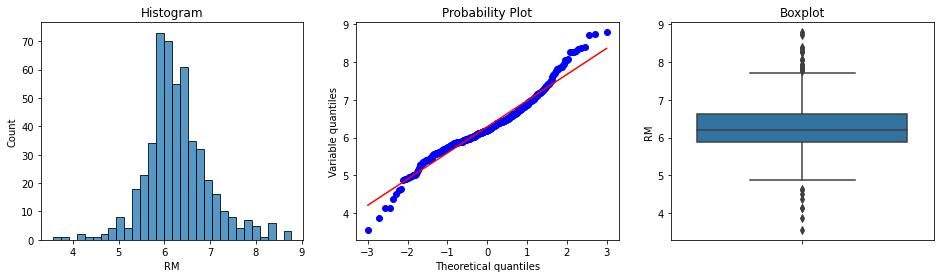

In [ ]:
diagnostic_plots(boston, 'RM')

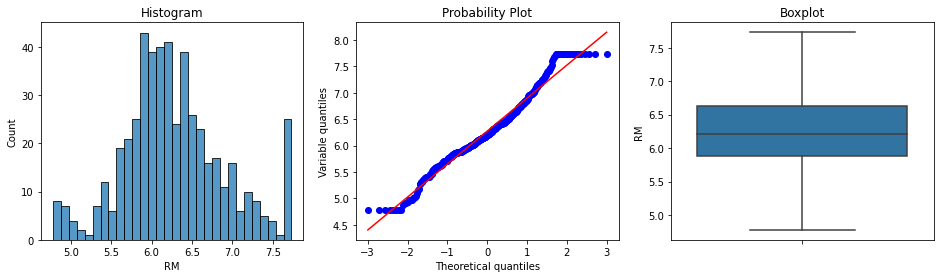

In [ ]:
diagnostic_plots(boston_t, 'RM')

In [ ]:
# 各変数の最小キャップを調べることができます。
windsoriser.left_tail_caps_

{'CRIM': -5.31051125, 'LSTAT': -8.057500000000005, 'RM': 4.778500000000001}

In [ ]:
# 各変数の最大値を調べることができます。
windsoriser.right_tail_caps_

{'CRIM': 9.06963875, 'LSTAT': 31.962500000000006, 'RM': 7.730499999999999}